# [Reproducible Data Analysis in Jupyter](http://jakevdp.github.io/blog/2017/03/03/reproducible-data-analysis-in-jupyter/)
[YouTube Playlist](https://www.youtube.com/playlist?list=PLYCpMb24GpOC704uO9svUrihl-HY1tTJJ)

## From exploratory analysis to reproducible science

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import os
from urllib.request import urlretrieve
from sklearn.decomposition import PCA

In [2]:
from jupyterworkflow.data import get_fremont_data #from [package.pyfile] import [function]

In [3]:
data = get_fremont_data()

In [4]:
!head Fremont.csv

Date,Fremont Bridge East Sidewalk,Fremont Bridge West Sidewalk
10/03/2012 12:00:00 AM,9,4
10/03/2012 01:00:00 AM,6,4
10/03/2012 02:00:00 AM,1,1
10/03/2012 03:00:00 AM,3,2
10/03/2012 04:00:00 AM,1,6
10/03/2012 05:00:00 AM,10,21
10/03/2012 06:00:00 AM,50,105
10/03/2012 07:00:00 AM,95,257
10/03/2012 08:00:00 AM,146,291


In [5]:
data.head()

,East,West,Total
Date,,,
2012-10-03 00:00:00,9.0,4.0,13.0
2012-10-03 01:00:00,6.0,4.0,10.0
2012-10-03 02:00:00,1.0,1.0,2.0
2012-10-03 03:00:00,3.0,2.0,5.0
2012-10-03 04:00:00,1.0,6.0,7.0


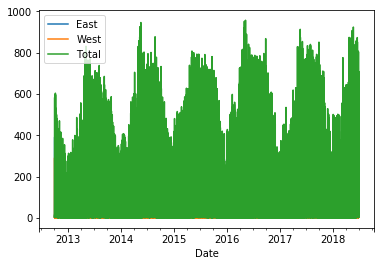

In [6]:
data.plot() #hourly counts on the course of 4 year, too much

## Resampling/GroupBy freq

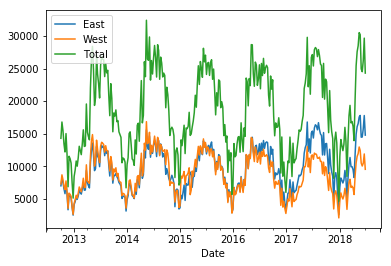

In [7]:
data.resample("W").sum().plot(); #do groupby by week and sum()
#more info about resampling here: http://benalexkeen.com/resampling-time-series-data-with-pandas/

## seaborn style

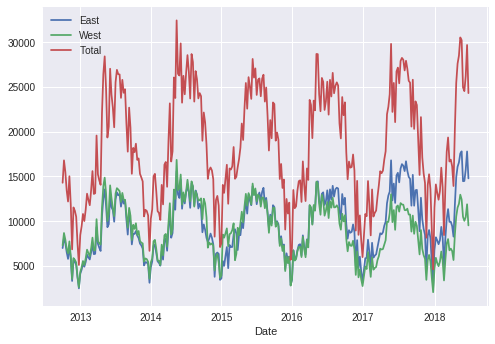

In [8]:
plt.style.use('seaborn')

data.resample("W").sum().plot(); #do groupby by week and sum()

## Detect trends using Rolling window (Moving Average)

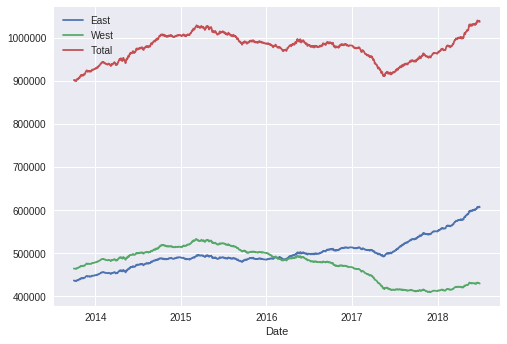

In [9]:
data.resample("D").sum().rolling(365).sum().plot(); #group by day and sum(), then add a 365 sum moving window
#This is the anual trend

(0, 1071703.9)

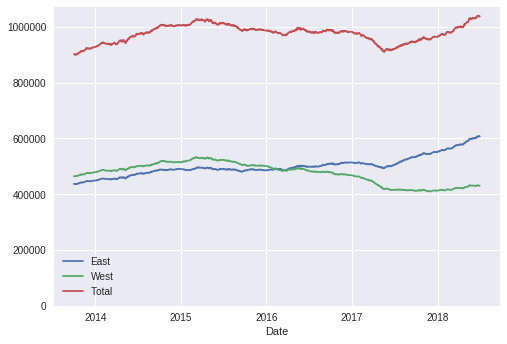

In [10]:
ax = data.resample("D").sum().rolling(365).sum().plot(); #group by day and sum(), then add a 365 sum moving window
#This is the anual trend

ax.set_ylim(0, None) #None is the current maximum

## Detect trends using Group by (time of day)

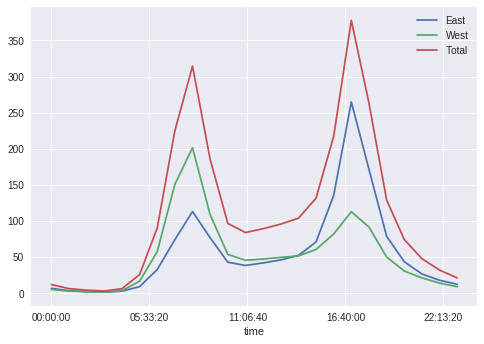

In [11]:
data.groupby(data.index.time).mean().plot();
#People are going in from the West, and out of the city from the East (less people are doing so - East in to West out)

## Pivot table: 
### See actual in-day activity (Expanding the group by)
[Pandas: group by and Pivot table difference](https://stackoverflow.com/a/34702851/1640414)
* Using groupby() puts the data in groups by key where **the values are in the rows**
* Using pivot_table() the data are grouped by the key and **the values are on the columns!**

In [12]:
pivoted = data.pivot_table('Total', index=data.index.time, columns=data.index.date) #rows by time column by date
pivoted.iloc[:5, :5] #take a snapshot

,2012-10-03,2012-10-04,2012-10-05,2012-10-06,2012-10-07
00:00:00,13.0,18.0,11.0,15.0,11.0
01:00:00,10.0,3.0,8.0,15.0,17.0
02:00:00,2.0,9.0,7.0,9.0,3.0
03:00:00,5.0,3.0,4.0,3.0,6.0
04:00:00,7.0,8.0,9.0,5.0,3.0


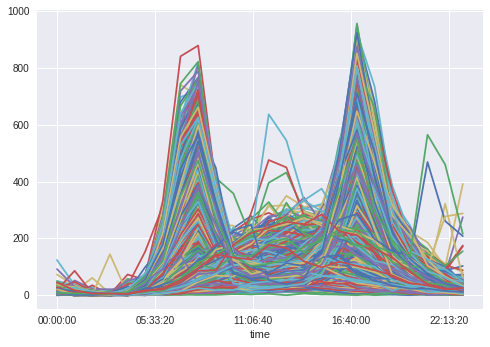

In [13]:
pivoted.plot(legend=False)

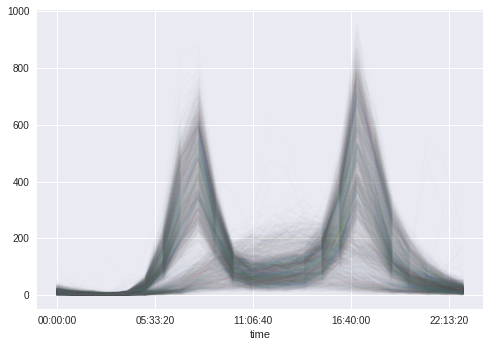

In [14]:
pivoted.plot(legend=False, alpha = 0.01)

**Because we've used alpha we can see 2 clusters of activity**, one is weekdays (working days) and the other one is non-working (days)

## Documentation

In [15]:
?get_fremont_data #get the documentation

In [16]:
??get_fremont_data #get the source code

## Dimensionality reduction

In [17]:
X = pivoted.T.values
X.shape

#lets treat each day as an observation with 24 (hours) dimensions

(2097, 24)

In [18]:
#X2 = PCA(2).fit_transform(X) #project it to 2 dims
#fails due to:
#ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [19]:
#lets handle nans
X = pivoted.fillna(0).T.values
X2 = PCA(2).fit_transform(X) #project it to 2 dims
X2.shape

(2097, 2)

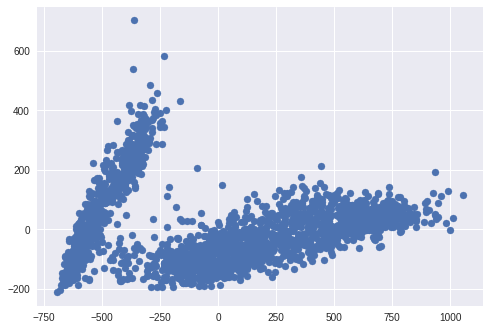

In [20]:
plt.scatter(X2[:, 0], X2[:, 1]) #getting 2 clusters

## Identify clusters using GMM

In [21]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(2) #2 clusters
gmm.fit(X)
labels = gmm.predict(X)
labels

array([1, 1, 1, ..., 1, 1, 0])

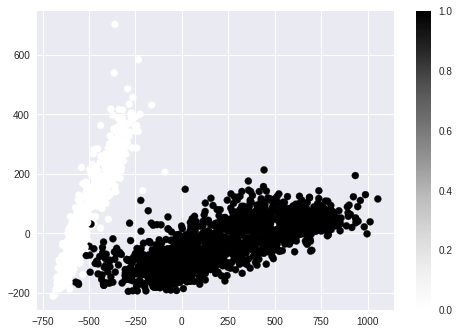

In [22]:
plt.scatter(X2[:, 0], X2[:, 1], c=labels) #plot clusters with colors
plt.colorbar()

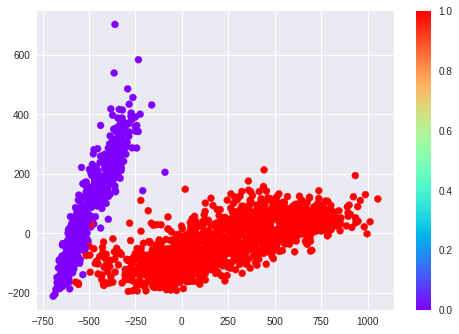

In [23]:
plt.scatter(X2[:, 0], X2[:, 1], c=labels, cmap='rainbow') #plot clusters with colors
plt.colorbar()

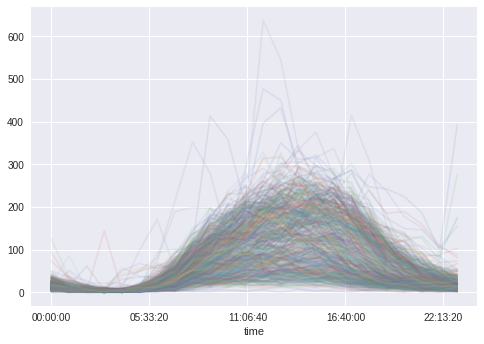

In [24]:
pivoted.T[labels == 0].T.plot(legend=False, alpha=0.1) #plot purple cluster (weekends | not working)

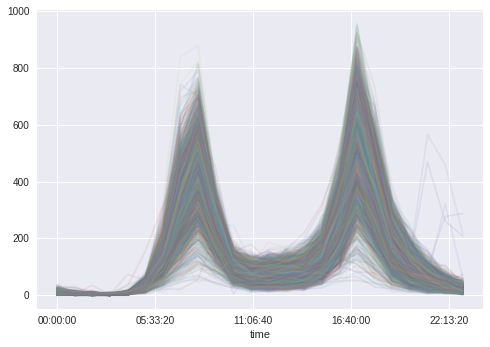

In [25]:
pivoted.T[labels == 1].T.plot(legend=False, alpha=0.1) #plot red cluster (week-days?)

Text(0.5,1,'Red Cluster')

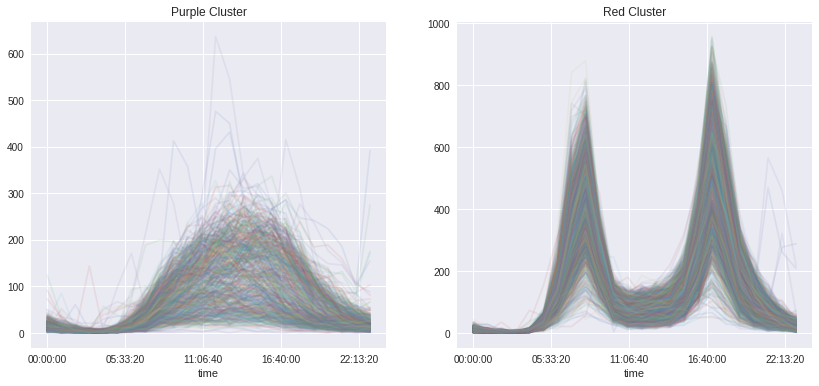

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(14,6))

pivoted.T[labels == 0].T.plot(legend=False, alpha=0.1, ax=ax[0]) #plot purple cluster (weekends | not working)
pivoted.T[labels == 1].T.plot(legend=False, alpha=0.1, ax=ax[1]) #plot red cluster (week-days?)

ax[0].set_title('Purple Cluster')
ax[1].set_title('Red Cluster')

## Let's find out what cluster is weekday and what clust is weekend

In [27]:
pivoted.columns #notice that dbtype is object

Index([2012-10-03, 2012-10-04, 2012-10-05, 2012-10-06, 2012-10-07, 2012-10-08,
       2012-10-09, 2012-10-10, 2012-10-11, 2012-10-12,
       ...
       2018-06-21, 2018-06-22, 2018-06-23, 2018-06-24, 2018-06-25, 2018-06-26,
       2018-06-27, 2018-06-28, 2018-06-29, 2018-06-30],
      dtype='object', length=2097)

In [28]:
#Let's color by weekday
dayofweek = pd.DatetimeIndex(pivoted.columns).dayofweek
dayofweek

Int64Index([2, 3, 4, 5, 6, 0, 1, 2, 3, 4,
            ...
            3, 4, 5, 6, 0, 1, 2, 3, 4, 5],
           dtype='int64', length=2097)

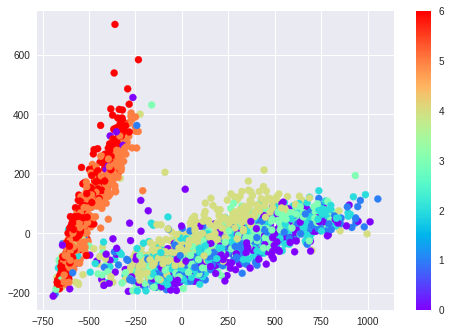

In [29]:
plt.scatter(X2[:, 0], X2[:, 1], c=dayofweek, cmap='rainbow') #plot clusters with colors
plt.colorbar()

Saturday is 5 and Sunday is 6

## look at the outliers

In [30]:
dates = pd.DatetimeIndex(pivoted.columns)
dates[(labels == 0) #non-working days cluster
     & (dayofweek < 5)] #non-weekends

DatetimeIndex(['2012-11-22', '2012-11-23', '2012-12-24', '2012-12-25',
               '2013-01-01', '2013-05-27', '2013-07-04', '2013-07-05',
               '2013-09-02', '2013-11-28', '2013-11-29', '2013-12-20',
               '2013-12-24', '2013-12-25', '2014-01-01', '2014-04-23',
               '2014-05-26', '2014-07-04', '2014-09-01', '2014-11-27',
               '2014-11-28', '2014-12-24', '2014-12-25', '2014-12-26',
               '2015-01-01', '2015-05-25', '2015-07-03', '2015-09-07',
               '2015-11-26', '2015-11-27', '2015-12-24', '2015-12-25',
               '2016-01-01', '2016-05-30', '2016-07-04', '2016-09-05',
               '2016-11-24', '2016-11-25', '2016-12-26', '2017-01-02',
               '2017-02-06', '2017-05-29', '2017-07-04', '2017-09-04',
               '2017-11-23', '2017-11-24', '2017-12-25', '2017-12-26',
               '2018-01-01', '2018-05-28'],
              dtype='datetime64[ns]', freq=None)

These are all holdays: _4th of july, labor day, Christmas, New year's eve_